In [1]:
import sys
sys.path.append("../src")  # relative path from notebooks/ to src/
from reflectivity_model import LayerSpec, ReflectivityModel, eVnm_converter
import reflectivity_model.utils as utils
import reflectivity_model.xray_compounds as xc

import numpy as np
from os import listdir
from os.path import isfile, join, expanduser
import pandas as pd
import matplotlib.pyplot as plt
import pint
unit = pint.UnitRegistry()
from scipy.optimize import differential_evolution, minimize

home = expanduser("~")
sys.path.append(join(home,'Projects/'))
import matrixmethod.mm_numba as mm #https://github.com/mikapfl/matrixmethod

### Import exp data

In [2]:
#ToDO: Check for polairzation if nothing is given, set it to s pol 100=s 190=p

def normalize_polarization(pol_entry):
    entry = str(pol_entry).lower()
    if '100' in entry or 's' in entry or '1' in entry:
        return 1
    elif '190' in entry or 'p' in entry or '0' in entry:
        return 0
    else:
        return 1  # default to s-pol if unclear


sample_name = 'simulated_reflectivity_pol' #the sample that we want to fit simulated_reflectivity
path = '../data/' #path to the reduced refelctivity data
onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('csv') and f.startswith(sample_name)]
print(onlyfiles_keys)

labels = []
exp_data_all = []

for file in onlyfiles_keys:
    label = file[:-4]  
    file = join(path, file)
    df = pd.read_csv(file)

    # Normalize column names
    if 'energy' in df.columns:
        df = df.rename(columns={'energy': 'Energy'})
    if 'sam_th' in df.columns:
        df = df.rename(columns={'sam_th': 'Theta'})

    # Add polarization column if missing
    if 'pol' not in df.columns:
        df['pol'] = 1  # default to s-polarization

    df['pol'] = df['pol'].apply(normalize_polarization)

    df['energy_pol'] = df.apply(
        lambda row: f"{row['Energy']}_{'p' if row['pol'] == 0 else 's'}",
        axis=1
    )


    df['file_name'] = label  
    df['E_round'] = np.round(df["Energy"], 1)

    labels.append(label)
    exp_data_all.append(df)



# Combine all data
combined_df = pd.concat(exp_data_all, ignore_index=True)


all_energy = np.asarray(combined_df['Energy'])
energy_uni = np.unique(all_energy)

energy_pol_uni = np.unique(combined_df['energy_pol'])

split_file = labels[0].split('_')
file_name = '_'.join(split_file[:3]) 
energy_pol_uni

['simulated_reflectivity_pol.csv']


array(['250.0_p', '250.0_s', '275.0_p', '275.0_s', '300.0_p', '300.0_s'],
      dtype=object)

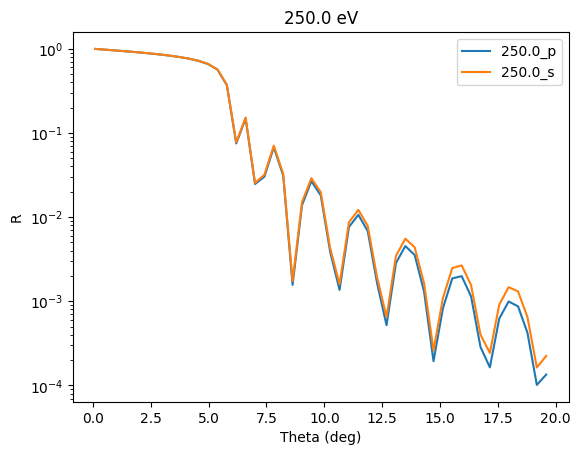

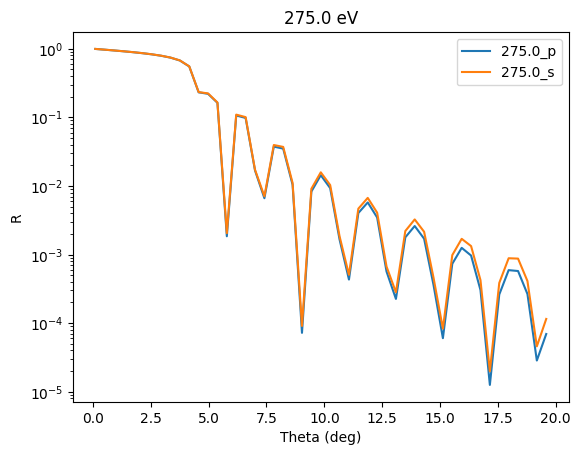

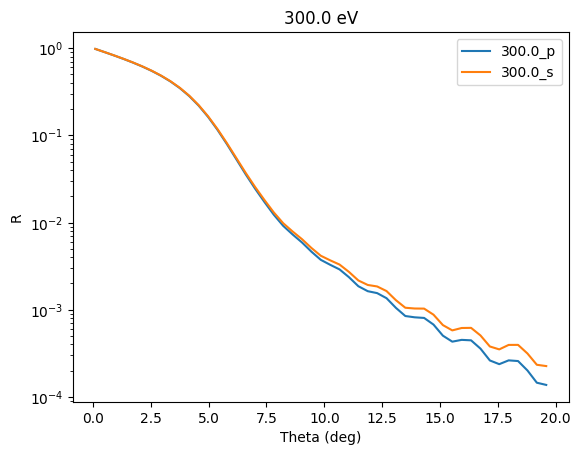

In [3]:
#Plot the relfectivity data for each energy
i_start = 0
i_end = -1
#labels_uni = np.unique(labels)
for i,E in enumerate(energy_uni):
    xrr_all = combined_df[combined_df['E_round']==E] 
    for iden in energy_pol_uni:
        subset = xrr_all[xrr_all['energy_pol'] == iden]
        if not subset.empty:
            plt.plot(subset['Theta'][i_start:i_end], subset['R'][i_start:i_end], '-', label=iden)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Theta (deg)')
    plt.ylabel('R')
    plt.title(str(E)+ ' eV')
    #plt.axvline(x=1, color='cyan')
    plt.show()

### Set up the model

In [4]:
def custom_sigma(R, model):
    return model.keys['a'] * R**2 + model.keys['b'] * R + model.keys['c']

energy_uni = []
for label in energy_pol_uni:
    energy_str, pol = label.split('_')
    energy = float(energy_str)
    energy_uni.append(energy)
nk_layer1 = np.conjugate(xc.refractive_index('SiO4C8H20',energy_uni* unit.eV,density=1.8))
n_array = 1-np.real(nk_layer1)
k_array = np.imag(nk_layer1)
#If you want to add anisotropic fixed layer you can use fixed_nk

model = ReflectivityModel(
    energy_pol_uni=energy_pol_uni,
    layers=[
        LayerSpec("resist_1")
            .fit_thickness(11, delta=5)
            .fit_roughness(0.009, bounds=(0, 1))
            #.fit_nk_from_material('SiO4C8H20', energy_pol_uni, delta_n=0.01, bounds_k=(0, 0.1), density=1.7),
            .fit_nk_array( n_array, k_array, delta_n=0.1, bounds_k=(0, 0.1)),
        LayerSpec("resist_2")
            .fit_thickness(51, bounds=(45, 55))
            .fit_roughness(3, bounds=(1, 6))
            .fit_nk_from_material('C8H6O', energy_pol_uni, bounds_n=(-0.05, 0.05), bounds_k=(0, 0.1), density=2.5),
        LayerSpec("oxide")
            .fixed_thickness(1.1)
            .fixed_roughness(1.0)
            .fixed_nk_from_material("SiO2", energy_pol_uni, density=2.09),
        LayerSpec("substrate", is_substrate=True)
            .fixed_roughness(1.0)
            .fixed_nk_from_material("Si", energy_pol_uni, density=2.33)
    ],
    global_params={
        'aoi_offset': {'fit': True, 'x0': 0.0, 'bounds': (-1, 1)},
        'darkcurrent': {'fit': False, 'value': 0.0},
        'a': {'fit': False, 'value': 0.045},
        'b': {'fit': False, 'value': 2.5e-5},
        #'c': {'fit': False, 'value': 2.5e-5}
    },
    fit_strategy="per_energy",
    sigma_mode="model",
    #sigma_function=custom_sigma
)

model.initialize_keys_from_x0()
model.summarize_stack(energy_pol_uni[0])
model.describe_sigma()
model.energy_index_map


📐 Stack Summary at 250.0_p eV
Layer          |   Thick. :            Bounds |   Rough. :            Bounds |    Δ (n) :            Bounds |    β (k) :            Bounds
------------------------------------------------------------------------------------------------------------------------
🔹 resist_1       |   11.000 :   [6.000, 16.000] |    0.009 :    [0.000, 1.000] |   0.0046 : [-0.0954, 0.1046] |   0.0007 :  [0.0000, 0.1000]
🔹 resist_2       |   51.000 :  [45.000, 55.000] |    3.000 :    [1.000, 6.000] |   0.0052 : [-0.0500, 0.0500] |   0.0003 :  [0.0000, 0.1000]
🔹 oxide          |    1.100 :                 — |    1.000 :                 — |   0.0055 :                 — |   0.0021 :                 —
🔹 substrate      |        — :                 — |    1.000 :                 — |   0.0060 :                 — |   0.0043 :                 —


{'250.0_p': {'index': 0, 'energy': 250.0, 'pol': 'p', 'pol_number': 0},
 '250.0_s': {'index': 1, 'energy': 250.0, 'pol': 's', 'pol_number': 1},
 '275.0_p': {'index': 2, 'energy': 275.0, 'pol': 'p', 'pol_number': 0},
 '275.0_s': {'index': 3, 'energy': 275.0, 'pol': 's', 'pol_number': 1},
 '300.0_p': {'index': 4, 'energy': 300.0, 'pol': 'p', 'pol_number': 0},
 '300.0_s': {'index': 5, 'energy': 300.0, 'pol': 's', 'pol_number': 1}}

### Set up Objective functions

In [5]:
def objective_inner(x, aoi, xrr, sigma_sq, E, model, pol,E_pol, return_R=False):
    # Update model keys with current fit parameters
    for i, param in enumerate([p for p in model.domain_E_init if f'_{E_pol}' in p['name']]):
        model.keys[param['name']] = x[i]

    # Build layer arrays for this energy
    layer, rough, n_stack = model.build_layer_arrays(E_pol)

    # Simulate reflectivity
    wl = utils.eVnm_converter(E)
    rm, tm = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=pol)
    rm = np.square(np.abs(np.asarray(rm)))

    chi = np.sum(np.square(rm - xrr) / sigma_sq)
    return (chi, rm) if return_R else chi

def objective_model_fit(x, model, combined_df, return_loglikelihood=False, return_all=False): 
    # Validate input length based on fit strategy
    global_keys = [k for k, v in model.global_params.items() if v.get('fit')]
    n_global = len(global_keys)
    n_energy = len(model.domain_E_init)  # total energy-dependent params

    if model.fit_strategy == "per_energy":
        if len(x) != n_global:
            raise ValueError(f"Expected {n_global} global parameters for 'per_energy' strategy, got {len(x)}")
    elif model.fit_strategy == "global":
        expected_total = n_global + n_energy
        if len(x) != expected_total:
            raise ValueError(f"Expected {expected_total} parameters (global + energy-dependent) for 'global' strategy, got {len(x)}")
    else:
        raise ValueError(f"Unknown fit strategy: {model.fit_strategy}")

    x_global = x[:n_global]
    x_energy = x[n_global:]

    # Update global parameters
    for i, key in enumerate(global_keys):
        model.keys[key] = x_global[i]

    # Initialize outputs
    chi_total = 0
    loglikelihood = 0
    if return_all:
        nk_E, R_E, R_exp_E, chi_E = [], [], [], []

    # Loop over energies
    for E_pol in model.energy_pol_uni:

        i = model.energy_index_map[E_pol]['index']
        E = model.energy_index_map[E_pol]['energy']
        pol = model.energy_index_map[E_pol]['pol_number']  #1 = s_plo, 0 = p_pol

        xrr_all = combined_df[combined_df['energy_pol'] == E_pol]
        aoi = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
        xrr = xrr_all['R'].values
        if model.sigma_mode == "model":
            sigma_sq = np.square(model.keys['a'] * xrr) + np.square(model.keys['b'])
        elif model.sigma_mode == "column":
            if model.sigma_column is None:
                raise ValueError("sigma_column must be specified when sigma_mode='column'")
            if model.sigma_column not in xrr_all.columns:
                raise ValueError(f"Column '{model.sigma_column}' not found in combined_df")
            sigma_sq = xrr_all[model.sigma_column].values
        elif model.sigma_mode == "function":
            if not callable(model.sigma_function):
                raise ValueError("sigma_function must be a callable when sigma_mode='function'")
            sigma_sq = model.sigma_function(xrr_all['R'].values, model)
        else:
            raise ValueError(f"Unknown sigma_mode: {model.sigma_mode}")


        if model.fit_strategy == "per_energy":
            # Fit energy-dependent parameters separately
            x0 = [d['x0'] for d in model.domain_E_init if f'_{E_pol}' in d['name']]
            bounds = [d['domain'] for d in model.domain_E_init if f'_{E_pol}' in d['name']]

            res = minimize(
                objective_inner, x0, bounds=bounds,
                args=(aoi, xrr, sigma_sq, E, model,pol,E_pol), method='TNC'
            )
            chi_E_val, rm = objective_inner(res.x, aoi, xrr, sigma_sq, E, model,pol,E_pol, return_R=True)

            if return_all:
                nk_E.append(res.x)

        elif model.fit_strategy == "global":
            # Use energy-dependent parameters from x
            energy_params = [p for p in model.domain_E_init if f'_{E_pol}' in p['name']]
            for i, param in enumerate(energy_params):
                model.keys[param['name']] = x_energy[i]

            wl = eVnm_converter(E)
            layer, rough, n_stack = model.build_layer_arrays(E_pol)
            rm, _ = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=pol)
            rm = np.square(np.abs(np.asarray(rm)))
            chi_E_val = np.sum(np.square(rm - xrr) / sigma_sq)

            if return_all:
                nk_E.append(x_energy)

        else:
            raise ValueError(f"Unknown fit_strategy: {model.fit_strategy}")

        chi_total += chi_E_val

        if return_loglikelihood:
            loglikelihood += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - chi_E_val / 2)

        if return_all:
            R_E.append(rm)
            R_exp_E.append(xrr)
            chi_E.append(chi_E_val)

    if return_loglikelihood:
        return loglikelihood
    if return_all:
        return np.asarray(nk_E), R_E, chi_E, chi_total

    return chi_total

### Do the fit

In [6]:


x0_global, bounds_global, global_keys = model.get_global_fit_params()
objective_model_fit(x0_global,model, combined_df)

x0_energy = [d['x0'] for d in model.domain_E_init]
bounds_energy = [d['domain'] for d in model.domain_E_init]

model.fit_strategy="per_energy"
x0 = x0_global# + x0_energy
bounds = bounds_global #+ bounds_energy

res = differential_evolution(
    func=objective_model_fit,
    bounds=bounds,
    args=(model, combined_df),
    strategy='best1bin',       # default strategy
    maxiter=10,              # increase for deeper convergence
    popsize=15,                # population size multiplier
    tol=1e-6,                  # convergence tolerance
    mutation=(0.5, 1.0),       # mutation range
    recombination=0.7,         # crossover probability
    polish=True,               # refine with local search at the end
    disp=True,                  # print progress
    workers=39
)

/home/kas/Projects/.venv/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 439.6843483563314
differential_evolution step 2: f(x)= 439.6843483563314
differential_evolution step 3: f(x)= 439.6843483563314
differential_evolution step 4: f(x)= 433.2781616503388
differential_evolution step 5: f(x)= 62.31329415403208
differential_evolution step 6: f(x)= 62.31329415403208
differential_evolution step 7: f(x)= 62.31329415403208
differential_evolution step 8: f(x)= 62.31329415403208
differential_evolution step 9: f(x)= 62.31329415403208
differential_evolution step 10: f(x)= 62.31329415403208
Polishing solution with 'L-BFGS-B'


### save as csv and plot

In [7]:
x0_global, bounds_global, global_keys = model.get_global_fit_params()
nk_E, R_E, chi_E, chi_total = objective_model_fit(res.x, model, combined_df, return_all=True)

model.save_all_fit_outputs(
    combined_df=combined_df,
    R_E=R_E,
    nk_E=nk_E,
    x_global=res.x[:len(global_keys)],
    global_keys=global_keys,
    folder_path="../fit_outputs",
    sample_name=sample_name
)

✅ Fit outputs saved to '../fit_outputs' with sample 'simulated_reflectivity_pol' and timestamp 20250911_134606


['250.0_p' '250.0_s' '275.0_p' '275.0_s' '300.0_p' '300.0_s']


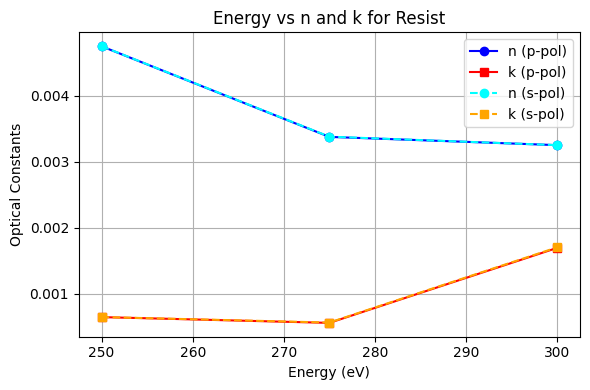

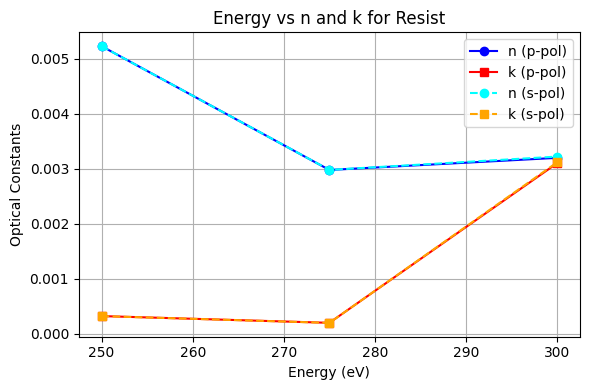

In [10]:
nk_E, R_E, chi_E, chi_total = objective_model_fit(
    res.x, model, combined_df, return_all=True
)
def extract_nk_for_layer(nk_E, layer_index):
    n_vals = [nk[layer_index * 2] for nk in nk_E]
    k_vals = [nk[layer_index * 2 + 1] for nk in nk_E]
    return n_vals, k_vals

def split_energy_by_polarization(energy_pol_uni, n_vals, k_vals):
    energy_p, n_p, k_p = [], [], []
    energy_s, n_s, k_s = [], [], []

    for label, n, k in zip(energy_pol_uni, n_vals, k_vals):
        energy_str, pol = label.split('_')
        energy = float(energy_str)

        if pol == 'p':
            energy_p.append(energy)
            n_p.append(n)
            k_p.append(k)
        elif pol == 's':
            energy_s.append(energy)
            n_s.append(n)
            k_s.append(k)

    return (energy_p, n_p, k_p), (energy_s, n_s, k_s)

energy_pol_uni = model.energy_pol_uni
n_vals = [nk[0] for nk in nk_E]  # assuming index 0 is n
k_vals = [nk[1] for nk in nk_E]  # assuming index 1 is k
print(energy_pol_uni)

def plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Layer"):
    plt.figure(figsize=(6, 4))

    # p-polarization
    plt.plot(energy_p, n_p, 'o-', label='n (p-pol)', color='blue')
    plt.plot(energy_p, k_p, 's-', label='k (p-pol)', color='red')

    # s-polarization
    plt.plot(energy_s, n_s, 'o--', label='n (s-pol)', color='cyan')
    plt.plot(energy_s, k_s, 's--', label='k (s-pol)', color='orange')

    plt.xlabel('Energy (eV)')
    plt.ylabel('Optical Constants')
    plt.title(f'Energy vs n and k for {layer_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

n_vals, k_vals = extract_nk_for_layer(nk_E, layer_index=0)
(energy_p, n_p, k_p), (energy_s, n_s, k_s) = split_energy_by_polarization(model.energy_pol_uni, n_vals, k_vals)
plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Resist")

n_vals, k_vals = extract_nk_for_layer(nk_E, layer_index=1)
(energy_p, n_p, k_p), (energy_s, n_s, k_s) = split_energy_by_polarization(model.energy_pol_uni, n_vals, k_vals)
plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Resist")


🔧 Fitted Parameters:
aoi_offset : -0.043560
thickness_resist_1 : 10.892368
rough_resist_1 : 0.385281
thickness_resist_2 : 48.950689
rough_resist_2 : 4.410228


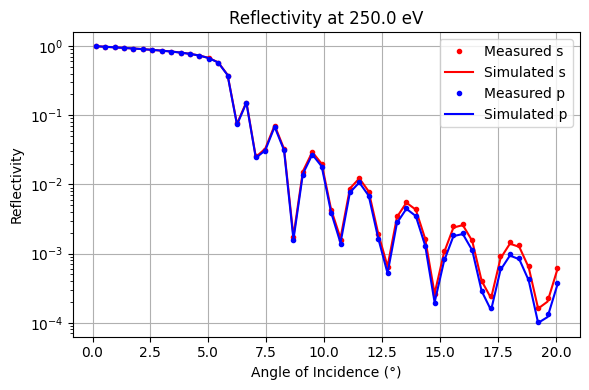

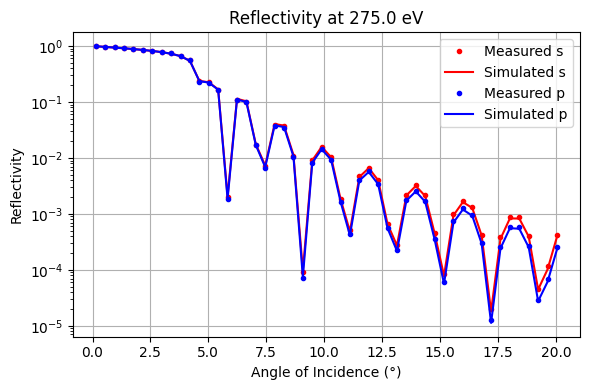

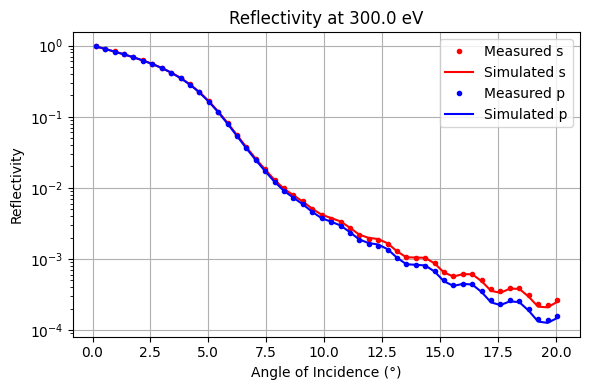

In [13]:
# Reconstruct keys
x_opt = res.x

# Get global keys
x0_global, bounds_global, global_keys = model.get_global_fit_params()
n_global = len(global_keys)

# Get energy-dependent keys
energy_keys = [d['name'] for d in model.domain_E_init]

# Combine all keys
all_keys = global_keys #+ energy_keys

# Print results
print("\n🔧 Fitted Parameters:")
for name, value in zip(all_keys, x_opt):
    print(f"{name} : {value:.6f}")

nk_E, R_E, chi_E, chi_total = objective_model_fit(
    res.x, model, combined_df, return_all=True
)

import matplotlib.pyplot as plt

def plot_reflectivity_results(model, combined_df, R_E):
    # Extract unique energies from energy_pol labels
    energy_values = sorted(set(float(ep.split('_')[0]) for ep in model.energy_pol_uni))

    for E in energy_values:
        plt.figure(figsize=(6, 4))
        plt.title(f'Reflectivity at {E:.1f} eV')
        plt.xlabel('Angle of Incidence (°)')
        plt.ylabel('Reflectivity')
        plt.yscale('log')
        plt.grid(True)

        for pol in ['s', 'p']:
            label = f"{E:.1f}_{pol}"
            if label not in model.energy_index_map:
                continue

            i = model.energy_index_map[label]['index']
            xrr_all = combined_df[combined_df['energy_pol'] == label]
            if xrr_all.empty:
                continue

            aoi_rad = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
            aoi_deg = np.rad2deg(aoi_rad)
            xrr = xrr_all['R'].values
            rm = R_E[i]

            color = 'red' if pol == 's' else 'blue'
            plt.plot(aoi_deg, xrr, '.', label=f'Measured {pol}', color=color)
            plt.plot(aoi_deg, rm, '-', label=f'Simulated {pol}', color=color)

        plt.legend()
        plt.tight_layout()
        plt.show()


plot_reflectivity_results(model, combined_df, R_E)
